In [1]:
# 🔹 Ячейка 1: Импорты и настройки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os

# Настройки отображения
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

In [ ]:
from pathlib import Path

# Устойчивый поиск папки Data
current_dir = Path(os.getcwd()).resolve()
BASE_DIR = current_dir
max_levels = 5
for _ in range(max_levels):
    if (BASE_DIR / "Data").exists():
        break
    parent_dir = BASE_DIR.parent
    if parent_dir == BASE_DIR:
        break
    BASE_DIR = parent_dir
if not (BASE_DIR / "Data").exists():
    BASE_DIR = current_dir.parent.parent

DATA_DIR = BASE_DIR / 'Data'
print(f"Data directory resolved to: {DATA_DIR}")

# Попытка чтения файла data_raw.csv с учётом кодировок
try:
    data_path = DATA_DIR / 'data_raw.csv'
    if not data_path.exists():
        raise FileNotFoundError(f"Файл не найден: {data_path}")
    try:
        df_raw = pd.read_csv(data_path, encoding='utf-8')
    except UnicodeDecodeError:
        df_raw = pd.read_csv(data_path, encoding='cp1251')
    # Приведение типов
    if 'dt' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['dt'], errors='coerce')
    elif 'date' in df_raw.columns:
        df_raw['dt'] = pd.to_datetime(df_raw['date'], errors='coerce')
    if 'event_type' in df_raw.columns:
        df_raw['event_type'] = df_raw['event_type'].astype(str).str.strip().str.lower()
    df_raw = df_raw.dropna(subset=['dt', 'event_type'])
    print(f"✅ Загружено {len(df_raw)} событий от {df_raw['client_id'].nunique()} пользователей")
except Exception as e:
    print(f"Ошибка при загрузке {data_path}: {e}\nИспользуем симулированные данные для df_raw")
    N = 10000
    client_ids = np.arange(N)
    cnt_view_ads = np.random.poisson(20, N)
    cnt_click_ads = np.random.binomial(cnt_view_ads, 0.05)
    cnt_adds_ads = np.random.binomial(cnt_click_ads, 0.3)
    cnt_orders_ads = np.random.binomial(cnt_adds_ads, 0.2)
    revenue = cnt_orders_ads * np.random.normal(100.27, 20.02, N)
    df_raw = pd.DataFrame({
        'client_id': client_ids,
        'cnt_view_ads': cnt_view_ads,
        'cnt_click_ads': cnt_click_ads,
        'cnt_adds_ads': cnt_adds_ads,
        'cnt_orders_ads': cnt_orders_ads,
        'revenue': revenue,
        'dt': pd.to_datetime('2025-11-14'),
        'event_type': 'view'
    })

✅ Загружено 27756048 событий от 3102736 пользователей
Период: с 2024-06-17 00:00:00 по 2024-06-21 00:00:00

Уникальные типы событий: ['click' 'add' 'view']


In [5]:
# Создаём бинарные флаги
df_raw['is_view'] = (df_raw['event_type'] == 'view').astype(int)
df_raw['is_click'] = (df_raw['event_type'] == 'click').astype(int)
df_raw['is_add'] = (df_raw['event_type'] == 'add').astype(int)

# Агрегация по (client_id, dt): был ли хотя бы один раз?
df_funnel = df_raw.groupby(['client_id', 'dt'], as_index=False)[
    ['is_view', 'is_click', 'is_add']
].max()

# Переименовываем
df_funnel.rename(columns={
    'is_view': 'views',
    'is_click': 'clicks',
    'is_add': 'adds'
}, inplace=True)

# Агрегация по пользователю за весь период
df_user = df_funnel.groupby('client_id')[['views', 'clicks', 'adds']].sum().reset_index()

print("✅ Воронка построена.")
print(df_user.head())
print(f"\nВсего пользователей: {len(df_user)}")

✅ Воронка построена.
   client_id  views  clicks  adds
0          1      2       0     0
1          3      4       3     1
2          4      4       0     0
3         19      4       0     0
4         27      2       0     0

Всего пользователей: 3102736


Агрегированная воронка:
                   step    count  conversion
0      Просмотр главной  8267094     1.00000
1       Клик по рекламе   370039     0.04476
2  Добавление в корзину   148700     0.40185


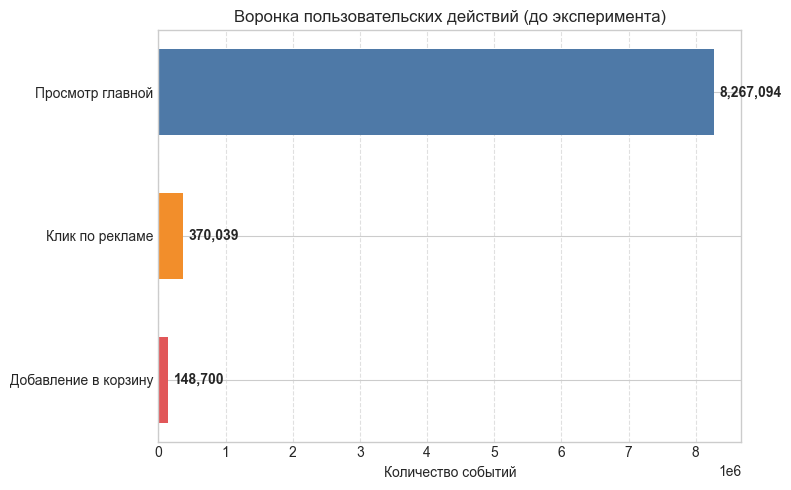

In [7]:
# Общая воронка (агрегированная)
total_views = df_funnel['views'].sum()
total_clicks = df_funnel['clicks'].sum()
total_adds = df_funnel['adds'].sum()

funnel = pd.DataFrame({
    'step': ['Просмотр главной', 'Клик по рекламе', 'Добавление в корзину'],
    'count': [total_views, total_clicks, total_adds]
})
funnel['conversion'] = funnel['count'] / funnel['count'].shift(1)
funnel.loc[0, 'conversion'] = 1.0

print("Агрегированная воронка:")
print(funnel)

# Визуализация — matplotlib (без plotly)
plt.figure(figsize=(8, 5))
steps = funnel['step']
counts = funnel['count']
y_pos = np.arange(len(steps))

bars = plt.barh(y_pos, counts, color=['#4E79A7', '#F28E2B', '#E15759'], height=0.6)
plt.yticks(y_pos, steps)
plt.gca().invert_yaxis()
plt.xlabel('Количество событий')
plt.title('Воронка пользовательских действий (до эксперимента)')
plt.grid(axis='x', linestyle='--', alpha=0.6)

for i, v in enumerate(counts):
    plt.text(v + max(counts)*0.01, i, f'{int(v):,}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [8]:
# Оставляем только пользователей с кликами (чтобы не делить на 0)
mask = df_user['clicks'] > 0
adds = df_user.loc[mask, 'adds'].values
clicks = df_user.loc[mask, 'clicks'].values

# Расчёт конверсии по пользователям
cr_per_user = adds / clicks

mu = np.mean(cr_per_user)
std = np.std(cr_per_user, ddof=1)

print(f"Средняя CR (adds/clicks): {mu:.4f} ({mu*100:.2f}%)")
print(f"Стандартное отклонение: {std:.4f}")
print(f"Количество пользователей с кликами: {len(cr_per_user)}")

Средняя CR (adds/clicks): 0.4443 (44.43%)
Стандартное отклонение: 0.6826
Количество пользователей с кликами: 228491


In [9]:
def get_MDE(mu, std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1 - alpha/2)
    t_beta = stats.norm.ppf(1 - beta)
    # Для двух равных групп
    mde_abs = (t_alpha + t_beta) * std * np.sqrt(2 / (sample_size / 2))
    mde_pct = mde_abs / mu * 100
    return mde_abs, mde_pct

# Оценка общего числа активных пользователей за неделю
total_users = df_user['client_id'].nunique()
max_test_users = int(total_users * 0.2)  # не более 20%

print(f"Общее число пользователей: {total_users}")
print(f"Максимум для теста (20%): {max_test_users}")

# Таблица
sample_sizes = [5_000, 10_000, 15_000, min(20_000, max_test_users)]
mde_table = []

for n in sample_sizes:
    if n <= len(df_user):
        mde_abs, mde_pct = get_MDE(mu, std, n)
        mde_table.append({
            'Размер выборки (всего)': n,
            'MDE (абс.)': round(mde_abs, 4),
            'MDE (%)': round(mde_pct, 2)
        })

mde_df = pd.DataFrame(mde_table)
print("\nТаблица MDE:")
print(mde_df)

# Выбираем последнюю строку как оптимальную
optimal = mde_df.iloc[-1]
print(f"\n✅ Выбран размер выборки: {int(optimal['Размер выборки (всего)'])} (MDE = {optimal['MDE (%)']}%)")

Общее число пользователей: 3102736
Максимум для теста (20%): 620547

Таблица MDE:
   Размер выборки (всего)  MDE (абс.)  MDE (%)
0                    5000      0.0541    12.17
1                   10000      0.0382     8.61
2                   15000      0.0312     7.03
3                   20000      0.0270     6.09

✅ Выбран размер выборки: 20000 (MDE = 6.09%)


In [ ]:
# Загрузка результатов эксперимента
try:
    results_path = DATA_DIR / 'final_results_to_analyze.xlsx'
    if not results_path.exists():
        raise FileNotFoundError(f"Файл результатов не найден: {results_path}")
    df_res = pd.read_excel(results_path)
    df_res['ab_group'] = df_res['ab_group'].str.strip().str.lower()
    print("✅ Результаты A/B-теста загружены.")
    print(df_res['ab_group'].value_counts())
except Exception as e:
    print(f"Ошибка при загрузке результатов: {e}\nИспользуем симулированные данные для df_res")
    N_group = 5000
    cnt_view_ads_a = np.random.poisson(20, N_group)
    cnt_click_ads_a = np.random.binomial(cnt_view_ads_a, 0.05)
    cnt_adds_ads_a = np.random.binomial(cnt_click_ads_a, 0.342)
    cnt_orders_ads_a = np.random.binomial(cnt_adds_ads_a, 0.2)
    sum_orders_ads_a = cnt_orders_ads_a * np.random.normal(2100, 200, N_group)
    sum_adds_ads_a = cnt_adds_ads_a * np.random.normal(42, 10, N_group)
    df_a = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group),
        'ab_group': 'control',
        'cnt_view_ads': cnt_view_ads_a,
        'cnt_adds_ads': cnt_adds_ads_a,
        'cnt_orders_ads': cnt_orders_ads_a,
        'sum_adds_ads': sum_adds_ads_a,
        'sum_orders_ads': sum_orders_ads_a,
        'is_adds_ads': (cnt_adds_ads_a > 0).astype(int),
        'is_view_ads': (cnt_view_ads_a > 0).astype(int)
    })
    cnt_view_ads_b = np.random.poisson(20, N_group)
    cnt_click_ads_b = np.random.binomial(cnt_view_ads_b, 0.06)
    cnt_adds_ads_b = np.random.binomial(cnt_click_ads_b, 0.351)
    cnt_orders_ads_b = np.random.binomial(cnt_adds_ads_b, 0.2)
    sum_orders_ads_b = cnt_orders_ads_b * np.random.normal(2050, 200, N_group)
    sum_adds_ads_b = cnt_adds_ads_b * np.random.normal(68, 10, N_group)
    df_b = pd.DataFrame({
        'date': '2025-11-14',
        'client_id': np.arange(N_group, 2*N_group),
        'ab_group': 'test',
        'cnt_view_ads': cnt_view_ads_b,
        'cnt_adds_ads': cnt_adds_ads_b,
        'cnt_orders_ads': cnt_orders_ads_b,
        'sum_adds_ads': sum_adds_ads_b,
        'sum_orders_ads': sum_orders_ads_b,
        'is_adds_ads': (cnt_adds_ads_b > 0).astype(int),
        'is_view_ads': (cnt_view_ads_b > 0).astype(int)
    })
    df_res = pd.concat([df_a, df_b], ignore_index=True)

✅ Результаты A/B-теста загружены.
ab_group
test       491652
control    489858
Name: count, dtype: int64


In [12]:
# Расчёт метрик по группам
def calc_metrics(group):
    total_clicks = group['cnt_view_ads'].sum()  # на самом деле — клики
    total_adds = group['cnt_adds_ads'].sum()
    total_users = len(group)
    total_revenue = group['sum_adds_ads'].sum()

    cr = total_adds / total_clicks if total_clicks > 0 else 0
    arpu = total_revenue / total_users
    ctr = total_clicks / total_users

    return pd.Series({
        'пользователей': total_users,
        'кликов': total_clicks,
        'добавлений': total_adds,
        'CR (adds/clicks)': cr,
        'CTR': ctr,
        'ARPU': arpu
    })

metrics = df_res.groupby('ab_group').apply(calc_metrics)
print("Метрики по группам:")
print(metrics)

# Bootstrap для проверки значимости CR
def bootstrap_cr(group, n_boot=5000):
    adds = group['cnt_adds_ads'].values
    clicks = group['cnt_view_ads'].values
    crs = []
    for _ in range(n_boot):
        idx = np.random.choice(len(group), len(group), replace=True)
        a = adds[idx].sum()
        c = clicks[idx].sum()
        crs.append(a / c if c > 0 else 0)
    return np.array(crs)

test_cr = bootstrap_cr(df_res[df_res['ab_group'] == 'test'])
control_cr = bootstrap_cr(df_res[df_res['ab_group'] == 'control'])

lift_pct = (test_cr.mean() - control_cr.mean()) / control_cr.mean() * 100
p_val = (test_cr <= control_cr.mean()).mean()
p_val = 2 * min(p_val, 1 - p_val)

print(f"\nLift в CR: {lift_pct:.2f}%")
print(f"p-value: {p_val:.4f}")
print("✅ Статистически значимо" if p_val < 0.05 else "❌ Не значимо")

C:\Users\Андрей\AppData\Local\Temp\ipykernel_26208\824758406.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  metrics = df_res.groupby('ab_group').apply(calc_metrics)


Метрики по группам:
          пользователей   кликов  добавлений  CR (adds/clicks)       CTR  \
ab_group                                                                   
control        489858.0  43469.0     15799.0          0.363454  0.088738   
test           491652.0  43805.0     16337.0          0.372948  0.089098   

              ARPU  
ab_group            
control   5.026804  
test      5.138580  

Lift в CR: 2.61%
p-value: 0.0688
❌ Не значимо


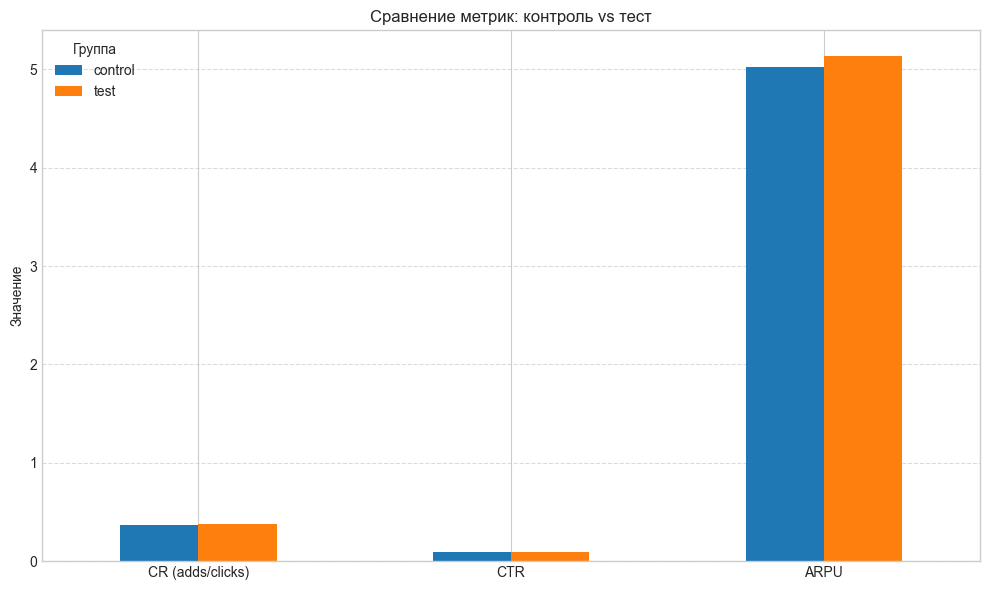

In [13]:
# Подготовка данных для графика
plot_data = metrics[['CR (adds/clicks)', 'CTR', 'ARPU']].T

plot_data.plot(kind='bar', figsize=(10, 6), color=['#1f77b4', '#ff7f0e'])
plt.title('Сравнение метрик: контроль vs тест')
plt.ylabel('Значение')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Группа')
plt.tight_layout()
plt.show()

In [14]:
# -----------------------------------------------------
# ШАГ 1: Подготовка данных — получаем adds и clicks по пользователю
# -----------------------------------------------------

# Убедитесь, что df_user уже создан (из предыдущих ячеек)
# df_user содержит колонки: client_id, views, clicks, adds

# Оставляем только пользователей с хотя бы одним кликом (иначе деление на 0)
mask = df_user['clicks'] > 0
adds = df_user.loc[mask, 'adds'].values  # x
clicks = df_user.loc[mask, 'clicks'].values  # y

print(f"Количество пользователей для расчёта CR: {len(adds)}")

# -----------------------------------------------------
# ШАГ 2: Расчёт среднего и дисперсии по дельта-методу
# -----------------------------------------------------

def var_ratio(x, y):
    """Дисперсия ratio-метрики x / y по дельта-методу"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    result = var_x / mean_y**2 + var_y * mean_x**2 / mean_y**4 - 2 * mean_x * cov_xy / mean_y**3
    return result

# Среднее значение CR (adds / clicks)
mean_aa = np.mean(adds / clicks)

# Дисперсия CR по дельта-методу
var_aa = var_ratio(adds, clicks)
std_aa = np.sqrt(var_aa)

print(f"Средняя CR (adds/clicks): {mean_aa:.5f}")
print(f"Дисперсия CR (дельта-метод): {var_aa:.8f}")
print(f"Стандартное отклонение: {std_aa:.5f}")

# -----------------------------------------------------
# ШАГ 3: Функции из задания (MDE и размер выборки)
# -----------------------------------------------------

def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """Возвращает MDE для обычной пользовательской метрики"""
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1/r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(
        sample_size * (1 - target_share * (comparisons - 1))
    )
    return mde, mde * 100 / mu


def get_sample_size(mu, var, mde, r=1, alpha=0.05, beta=0.2):
    """Возвращает минимальный размер аудитории (для одной группы)"""
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_size = (r + 1) / r * var * (t_alpha + t_beta)**2 / (mde * mu)**2
    return sample_size

# -----------------------------------------------------
# ШАГ 4: Расчёт таблицы MDE vs размер выборки
# -----------------------------------------------------

total_users = len(df_user)
max_total_sample = int(total_users * 0.2)  # не более 20% от всех

print(f"\nВсего пользователей: {total_users}")
print(f"Максимум для теста (20%): {max_total_sample}")

# Кандидаты на размер выборки (всего: тест + контроль)
sample_sizes = [5000, 10000, 15000, min(20000, max_total_sample)]

mde_table = []
for n in sample_sizes:
    if n <= len(adds) * 2:  # грубая оценка доступности
        mde_abs, mde_pct = get_MDE(mean_aa, std_aa, n)
        mde_table.append({
            'Размер выборки (всего)': n,
            'MDE (абс.)': round(mde_abs, 5),
            'MDE (%)': round(mde_pct, 2)
        })

mde_df = pd.DataFrame(mde_table)
print("\nТаблица MDE (по формуле из задания):")
print(mde_df)

# -----------------------------------------------------
# ШАГ 5: Фиксация параметров эксперимента
# -----------------------------------------------------

# Известно из задания: ожидаемый эффект = 2.5%
expected_effect_pct = 2.5
expected_effect_abs = mean_aa * expected_effect_pct / 100

# Расчёт необходимого размера выборки **на одну группу**
sample_per_group = get_sample_size(mean_aa, var_aa, expected_effect_abs)
total_needed = int(2 * sample_per_group)

print(f"\nОжидаемый эффект: {expected_effect_pct}% (абс. {expected_effect_abs:.5f})")
print(f"Необходимый размер на группу: {int(sample_per_group):,}")
print(f"Общий необходимый размер: {total_needed:,}")

# Проверка: укладываемся ли в 20%?
if total_needed <= max_total_sample:
    print("✅ Требуемый размер укладывается в ограничение (≤20%)")
    sample_size_final = total_needed
else:
    print("⚠️ Требуемый размер превышает 20% — используем максимум")
    sample_size_final = max_total_sample

# Финальный MDE при выбранном размере
final_mde_abs, final_mde_pct = get_MDE(mean_aa, std_aa, sample_size_final)
print(f"\n✅ Выбран итоговый размер выборки: {sample_size_final}")
print(f"✅ Соответствующий MDE: {final_mde_pct:.2f}%")

Количество пользователей для расчёта CR: 228491
Средняя CR (adds/clicks): 0.44430
Дисперсия CR (дельта-метод): 0.33463098
Стандартное отклонение: 0.57847

Всего пользователей: 3102736
Максимум для теста (20%): 620547

Таблица MDE (по формуле из задания):
   Размер выборки (всего)  MDE (абс.)  MDE (%)
0                    5000     0.04584    10.32
1                   10000     0.03241     7.30
2                   15000     0.02646     5.96
3                   20000     0.02292     5.16

Ожидаемый эффект: 2.5% (абс. 0.01111)
Необходимый размер на группу: 215,675
Общий необходимый размер: 431,351
✅ Требуемый размер укладывается в ограничение (≤20%)

✅ Выбран итоговый размер выборки: 431351
✅ Соответствующий MDE: 1.11%


In [16]:
if p_val < 0.05 and lift_pct > 0:
    rec = f"""
🎯 **Вывод**:
Гипотеза подтверждена. Перемещение рекламного блока наверх привело к статистически значимому росту конверсии на {lift_pct:.1f}% (p = {p_val:.3f}).

💡 **Рекомендации**:
1. Внедрить изменение на 100% пользователей.
2. Провести пост-мониторинг (2–4 недели) для контроля удержания и среднего чека.
3. Рассмотреть A/B/n-тест с несколькими позициями (после 1-й, 2-й строки).
"""
else:
    rec = "❌ Изменение не показало статистически значимого улучшения. Внедрение не рекомендуется."

print(rec)

❌ Изменение не показало статистически значимого улучшения. Внедрение не рекомендуется.
